# Mapping digit-representations in the human primary somatosensory cortex and their layer-dependent functional connectivity at 7T.

In this notebook, we are describing and, where possible, performing the preprocessing of this publication.

In [7]:
# basic
import glob
import itertools
import pandas as pd
import numpy as np
import os

# plotting
from nilearn import plotting
from scipy import ndimage
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

# neuroimaging
from nilearn.connectome import ConnectivityMeasure
import nibabel as nb
from nibabel import load, save, Nifti1Image
import nipype.interfaces.fsl as fsl
import nilearn
import ants

# misc
from scipy.ndimage import morphology
from scipy import stats
from scipy import interpolate
import imageio
import scipy
from scipy import ndimage
from IPython.display import clear_output


%matplotlib inline

## locating the data

Because the data location will be different for every machine, we will first define a root folder that we will use from then on.

In [8]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'

In this folder, we will find the find the nifti data and the derivatives folder, which will contain our processed data and analyses.


Next, we can make a list of participant-identifiers:

In [9]:
subFolders = sorted(glob.glob(root + '/sub*'))
subs = [i[-6:] for i in subFolders]

In [10]:
subs

['sub-02',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-09',
 'sub-10',
 'sub-12',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18']

For this analysis, we have generated a few manual masks. While running the code in this notebook will give you the automatically generated bases, we have often worked with this data. For example, we have manually improved the automatic segmentations. On the other hand, there are some masks that we created from scratch. For example the masks, we used for motion correction or registration.

All of these masks are foud here (**include link**) and should be placed in the derivatives folder with the name "manualSteps".

In the derivatives folder, we will also have to make a new folders for each subject to store the output of the anatomical and function data.

In [176]:
%%bash -s "{" ".join(subs)}" "$root"

for sub in $1
do
mkdir -p $2/derivatives/$sub/anat
mkdir -p $2/derivatives/$sub/func/confoundRegressors


done

mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/misc’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-05/func’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-06/func’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-07/func’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-09/func’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-10/func’: File exists
mkdir: cannot create directory ‘/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func’: File

## Motion correction

To account for non-linear distortions due to low bandwidth, a manually drawn motion mask covering the postcentral gyrus was used to optimize registration on our target region. Mask selection was guided by the raw EPI data. Here, we plot the mask with the first volume of the resting state run for one participant as an example.

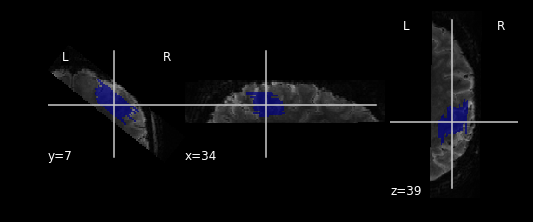

In [33]:
for sub in subs[:1]:
    motionMask = f'{root}/derivatives/manualSteps/{sub}/{sub}_moma.nii'
    restRun = glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-001_cbv.nii.gz')
    
    underlaySlice = nb.load(restRun[0]).get_fdata()[:,:,:,0]
    
    motionMaskData = nb.load(motionMask)
    
    new_img = nb.Nifti1Image(underlaySlice, motionMaskData.affine, motionMaskData.header)
    
    display = plotting.plot_roi(motionMaskData, new_img)

### Motion-correction

For each subject, we want to register all runs to the resting state data. Therefore, we will first do the motion correction for those first.

In [115]:
%%bash


for sub in 02 05 06 07 09 10 12 15 16 17 18
do

echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''


declare -a runs=('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*rest*run-*_cbv.nii.gz')


cd '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-'$sub'/func'


for run in $runs
do

# define basename for output files
base=`basename $run _cbv.nii.gz`
echo 'processing run '$base''


mkdir -p motionParameters/${base}/nn_motion
mkdir -p motionParameters/${base}/n_motion

###########################################
###### parameters that are not used  ######
###########################################

ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=8
export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS
tr=1
basevol=1000 # ANTs indexing

###########################################
####### preparig odd and even images ######
###########################################

#for classical Magentom VASO sequences
3dcalc -a ${run}'[0..$(2)]' -expr 'a' -prefix ${base}_notnulled.nii -overwrite
3dcalc -a ${run}'[1..$(2)]' -expr 'a' -prefix ${base}_nulled.nii -overwrite

###########################################
####### Do MOCO on notnulled  #############
###########################################

n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_notnulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
3dMean -prefix ${base}_nn_reference.nii vol_1004.nii vol_1005.nii # there is no overwrite here, in case of multiple series
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x '../misc/sub-'$sub'_moma.nii' \
--initial-moving-transform [ ${base}_nn_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ${base}_nn_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ nn_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0vox
done

echo "reassembling the time points"
ImageMath 4 ${base}_moco_notnulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/${base}/nn_motion
mv vol_*_0GenericAffine.mat motionParameters/${base}/nn_motion
mv vol_*_InverseWarped.nii.gz motionParameters/${base}/nn_motion
mv vol_*_Warped.nii.gz motionParameters/${base}/nn_motion


###########################################
####### Do MOCO on nulled  ################
###########################################

n_vols=`PrintHeader ${base}_nulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_nulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
3dMean -prefix ${base}_n_reference.nii vol_1004.nii vol_1005.nii # there is no overwrite here, in case of multiple series
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x '../misc/sub-'$sub'_moma.nii' \
--initial-moving-transform [ ${base}_n_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ${base}_n_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ n_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0voxdone
done
echo "reassembling the time points"
ImageMath 4 ${base}_moco_nulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/${base}/n_motion
mv vol_*_0GenericAffine.mat motionParameters/${base}/n_motion
mv vol_*_Warped.nii.gz motionParameters/${base}/n_motion
mv vol_*_InverseWarped.nii.gz motionParameters/${base}/n_motion


##############################
#### fsl_motion_outliers  ####
##############################

fsl_motion_outliers -i ${base}_nulled.nii -o confoundRegressors/${base}_VASO_confounds.txt
fsl_motion_outliers -i ${base}_notnulled.nii -o confoundRegressors/${base}_BOLD_confounds.txt


done
done





processing sub-02
processing run sub-02_ses-003_task-restBA3b_run-001




processing sub-05
processing run sub-05_ses-002_task-restBA3b_run-001




processing sub-06
processing run sub-06_ses-001_task-restBA3b_run-001




processing sub-07
processing run sub-07_ses-001_task-restBA3b_run-001




processing sub-09
processing run sub-09_ses-001_task-restBA3b_run-001




processing sub-10
processing run sub-10_ses-001_task-restBA3b_run-001




processing sub-12
processing run sub-12_ses-001_task-restBA3b_run-001




processing sub-15
processing run sub-15_ses-001_task-restBA3b_run-001




processing sub-16
processing run sub-16_ses-001_task-restBA3b_run-001




processing sub-17
processing run sub-17_ses-001_task-restBA3b_run-001




processing sub-18
processing run sub-18_ses-001_task-restBA3b_run-001


### Stimulation 

After the motion correction is completed for the resting state data, we can run almost the same code for the stimulation data but use the reference images from the resting-state data.

In [116]:
%%bash


for sub in 02 05 06 07 09 10 12 15 16 17 18
do

echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''


restrun='/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*rest*run-*_cbv.nii.gz'
restbase=`basename $restrun _cbv.nii.gz`
echo $restbase


declare -a runs=('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*stim*run-*_cbv.nii.gz')


cd '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-'$sub'/func'


for run in $runs
do

# define basename for output files
base=`basename $run _cbv.nii.gz`
echo 'processing run '$base''


# mkdir -p motionParameters/${base}/nn_motion
# mkdir -p motionParameters/${base}/n_motion

# ###########################################
# ###### parameters that are not used  ######
# ###########################################

# ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=8
# export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS
# tr=1
# basevol=1000 # ANTs indexing

# ###########################################
# ####### preparig odd and even images ######
# ###########################################

# #for classical Magentom VASO sequences
# 3dcalc -a ${run}'[0..$(2)]' -expr 'a' -prefix ${base}_notnulled.nii -overwrite
# 3dcalc -a ${run}'[1..$(2)]' -expr 'a' -prefix ${base}_nulled.nii -overwrite

# ###########################################
# ####### Do MOCO on notnulled  #############
# ###########################################

# n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

# echo "seperating $n_vols time steps to save RAM"
# ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_notnulled.nii # vol_1000.nii, vol_1001.nii ...
# cp vol_1003.nii vol_1000.nii # removing steady state effects
# cp vol_1004.nii vol_1001.nii
# cp vol_1005.nii vol_1002.nii
# nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
# echo "doing the alignemt"
# for i in $(eval echo "{$basevol..$nthvol}");
# do
# antsRegistration \
# --dimensionality 3 \
# --float 1 \
# --collapse-output-transforms 1 \
# --output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
# --interpolation BSpline[2] \
# --use-histogram-matching 1 \
# --winsorize-image-intensities [ 0.005,0.995 ] \
# -x '../misc/sub-'$sub'_moma.nii' \
# --initial-moving-transform [ ${restbase}_nn_reference.nii,vol_${i}.nii,1 ] \
# --transform Rigid[ 0.1 ] \
# --metric MI[ ${restbase}_nn_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
# --convergence [ 250x100,1e-6,10 ] \
# --shrink-factors 2x1 \
# --smoothing-sigmas 1x0vox
# #--transform SyN[ 0.1,3,0 ] \
# #--metric CC[ nn_reference.nii,vol_${i}.nii,1,4 ] \
# #--convergence [ 50x0,1e-6,10 ] \
# #--shrink-factors 2x1 \
# #--smoothing-sigmas 1x0vox
# done

# echo "reassembling the time points"
# ImageMath 4 ${base}_moco_notnulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
# mv vol_*.nii motionParameters/${base}/nn_motion
# mv vol_*_0GenericAffine.mat motionParameters/${base}/nn_motion
# mv vol_*_InverseWarped.nii.gz motionParameters/${base}/nn_motion
# mv vol_*_Warped.nii.gz motionParameters/${base}/nn_motion


# ###########################################
# ####### Do MOCO on nulled  ################
# ###########################################

# n_vols=`PrintHeader ${base}_nulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

# echo "seperating $n_vols time steps to save RAM"
# ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_nulled.nii # vol_1000.nii, vol_1001.nii ...
# cp vol_1003.nii vol_1000.nii # removing steady state effects
# cp vol_1004.nii vol_1001.nii
# cp vol_1005.nii vol_1002.nii
# nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
# echo "doing the alignemt"
# for i in $(eval echo "{$basevol..$nthvol}");
# do
# antsRegistration \
# --dimensionality 3 \
# --float 1 \
# --collapse-output-transforms 1 \
# --output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
# --interpolation BSpline[2] \
# --use-histogram-matching 1 \
# --winsorize-image-intensities [ 0.005,0.995 ] \
# -x '../misc/sub-'$sub'_moma.nii' \
# --initial-moving-transform [ ${restbase}_n_reference.nii,vol_${i}.nii,1 ] \
# --transform Rigid[ 0.1 ] \
# --metric MI[ ${restbase}_n_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
# --convergence [ 250x100,1e-6,10 ] \
# --shrink-factors 2x1 \
# --smoothing-sigmas 1x0vox
# #--transform SyN[ 0.1,3,0 ] \
# #--metric CC[ n_reference.nii,vol_${i}.nii,1,4 ] \
# #--convergence [ 50x0,1e-6,10 ] \
# #--shrink-factors 2x1 \
# #--smoothing-sigmas 1x0voxdone
# done
# echo "reassembling the time points"
# ImageMath 4 ${base}_moco_nulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
# mv vol_*.nii motionParameters/${base}/n_motion
# mv vol_*_0GenericAffine.mat motionParameters/${base}/n_motion
# mv vol_*_Warped.nii.gz motionParameters/${base}/n_motion
# mv vol_*_InverseWarped.nii.gz motionParameters/${base}/n_motion


# ##############################
# #### fsl_motion_outliers  ####
# ##############################

fsl_motion_outliers -i ${base}_nulled.nii -o confoundRegressors/${base}_VASO_confounds.txt
fsl_motion_outliers -i ${base}_notnulled.nii -o confoundRegressors/${base}_BOLD_confounds.txt

done
done





processing sub-02
sub-02_ses-003_task-restBA3b_run-001
processing run sub-02_ses-003_task-stim_run-001
processing run sub-02_ses-003_task-stim_run-002




processing sub-05
sub-05_ses-002_task-restBA3b_run-001
processing run sub-05_ses-002_task-stim_run-001




processing sub-06
sub-06_ses-001_task-restBA3b_run-001
processing run sub-06_ses-001_task-stim_run-001




processing sub-07
sub-07_ses-001_task-restBA3b_run-001
processing run sub-07_ses-001_task-stim_run-001
processing run sub-07_ses-001_task-stim_run-002




processing sub-09
sub-09_ses-001_task-restBA3b_run-001
processing run sub-09_ses-001_task-stim_run-001




processing sub-10
sub-10_ses-001_task-restBA3b_run-001
processing run sub-10_ses-001_task-stim_run-001




processing sub-12
sub-12_ses-001_task-restBA3b_run-001
processing run sub-12_ses-001_task-stim_run-001
processing run sub-12_ses-001_task-stim_run-002
processing run sub-12_ses-001_task-stim_run-003
processing run sub-12_ses-001_task-stim_run-004




process

## Motion-Parameters

Here, we want to get the motion-parameters. Because ANTs does not save real world parameters, we will transfer the affine matrices into FSL format.

In [206]:
subs

['sub-02',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-09',
 'sub-10',
 'sub-12',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18']

In [211]:
%%bash

imageTypes=("n" "nn")


for sub in 02 05 06 07 09 10 12 15 16 17 18
do

declare -a runs=('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*run-*_cbv.nii.gz')

restrun='/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*rest*run-*_cbv.nii.gz'
restbase=`basename $restrun _cbv.nii.gz`
echo 'The reference image is: '$restbase''

cd '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-'$sub'/func'


for run in $runs
do

# define basename for output files
base=`basename $run _cbv.nii.gz`
echo 'processing run '$base''

n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`
num=$((n_vols + 1000))


for imageType in "${imageTypes[@]}"
do


for (( k=1000; k<$num; k++ ))
do
ConvertTransformFile \
3 \
'motionParameters/'${base}'/'$imageType'_motion/vol_'$k'_0GenericAffine.mat' \
'motionParameters/'${base}'/'$imageType'_motion/vol_'$k'_0GenericAffine_af.mat' \
--convertToAffineType


c3d_affine_tool \
-ref ''${restbase}'_'$imageType'_reference.nii' \
-src 'motionParameters/'${base}'/'$imageType'_motion/vol_'$k'.nii' \
-itk 'motionParameters/'${base}'/'$imageType'_motion/vol_'$k'_0GenericAffine_af.mat' -ras2fsl \
-o 'motionParameters/'${base}'/'$imageType'_motion/vol_'$k'_0GenericAffine_FSL.mat' \
-info-full

done
done
done
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Exception raised during processing:
/home/picsl/tk/bb3/Nightly/itk/v4.5.2/itk/Modules/IO/ImageBase/include/itkImageFileReader.hxx:143:
 Could not create IO object for file motionParameters/sub-02_ses-003_task-stim_run-001/n_motion/vol_1202.nii
The file doesn't exist. 
Filename = motionParameters/sub-02_ses-003_task-stim_run-001/n_motion/vol_1202.nii

Exception raised during processing:
/home/picsl/tk/bb3/Nightly/itk/v4.5.2/itk/Modules/IO/ImageBase/include/itkImageFileReader.hxx:143:
 Could not create IO object for file motionParameters/sub-02_ses-003_task-stim_run-002/n_motion/vol_1201.nii
The file doesn't exist. 
Filename = motionParameters/sub-02_ses-003_task-st

Then we can read the matrices and extract the motion traces.

In [47]:
%%bash

for sub in 02 05 06 07 09 10 12 15 16 17 18
do
cd '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-'$sub'/func'
mkdir confoundRegressors

done

mkdir: cannot create directory ‘confoundRegressors’: File exists


In [127]:
modalities = ["n", 'nn']
modalitiesDict = {'n': 'VASO', 'nn': 'BOLD'}


for sub in subs[:1]:
    print('')
    print('')
    print('')
    print('')
    print('')
    print(f'Processing {sub}')
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-*run-00*_cbv.nii.gz'))
    
    for run in runs:
        
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(f'Processing run {base}')
        
        
        motionList  = []
        motionNameList  = []
        trList = []
        subList =[]
        modalityList = []
    
        for modality in modalities:
            
            modalityMotionList = []
        
            affinemats = sorted(glob.glob(f'{root}/derivatives/{sub}/func/motionParameters/{base}/{modality}_motion/vol_*_0GenericAffine_FSL.mat'))
            print(f'Found {len(affinemats)} matrix-files')

            volids=[]
            for n in range(len(affinemats)):
                volids.append(n+1000)

            for volid in volids:

                # Current mats
                currMats = f'{root}/derivatives/{sub}/func/motionParameters/{base}/{modality}_motion/vol_{volid}_0GenericAffine_FSL.mat'

                tmp = fsl.AvScale(all_param=True,mat_file=currMats)

                tmpReadout = tmp.run()

                # Get the rotations (in rads) and translations (in mm) per volume

                aryTmpMot = list(itertools.chain.from_iterable(
                                            [tmpReadout.outputs.translations,
                                             tmpReadout.outputs.rot_angles]))




                # Save the roation and translations
                modalityMotionList.append(aryTmpMot) 
                
                
                motionList.append(aryTmpMot)
                trList.append([int(volid)+1-1000 for i in range(6)])               
                motionNameList.append([f'TX',f'TY',f'TZ',f'RX',f'RY',f'RZ'])
                subList.append([str(sub) for i in range(6)])
                modalityList.append([str(modalitiesDict[modality]) for i in range(6)])
                
             
            modalityMotionArr = np.array(modalityMotionList)
            
            arr = np.empty((modalityMotionArr.shape[0]*2,modalityMotionArr.shape[1]))
            
            for n in range(modalityMotionArr.shape[1]):
                
                tmp = modalityMotionArr[:,n].transpose()
                
                x = np.arange(0, tmp.shape[0])
                
                interp = interpolate.interp1d(x, tmp, kind='linear', bounds_error=None, fill_value= 'extrapolate')

                xUp = np.arange(0, tmp.shape[0],0.5)
                new = interp(xUp)

                arr[:,n]= stats.zscore(new)

            np.savetxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{str(modalitiesDict[modality])}_motionParameters.txt', arr, delimiter=' ')
            
    
    
        # Make flat arrays
        motionArr = np.array(motionList)
        motionArr =  motionArr.reshape((motionArr.size,-1)).copy()

        trArr = np.array(trList)
        trArr =  trArr.reshape((trArr.size,-1)).copy()   

        motionNameArr = np.array(motionNameList)
        motionNameArr =  motionNameArr.reshape((motionNameArr.size,-1)).copy()

        subArr = np.array(subList)
        subArr =  subArr.reshape((subArr.size,-1)).copy()

        modalityArr = np.array(modalityList)
        modalityArr =  modalityArr.reshape((modalityArr.size,-1)).copy()
    
        # make data as dict
        data_dict = {
        'subject': subArr[:,0],
        'tr': trArr[:,0],
        'motionName': motionNameArr[:,0],
        'motion': motionArr[:,0],
        'modality': modalityArr[:,0]}
        
        # convert to dataframe and save to disk
        df = pd.DataFrame(data=data_dict)
        df.to_csv(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_motionParameters.csv', index=False)
        
        clear_output(wait=True)
        print(f'Done with {base}')
            
 

Done with sub-02_ses-003_task-stim_run-002


### upsample motion outliers

In [122]:
modalities = ["n", 'nn']
modalitiesDict = {'n': 'VASO', 'nn': 'BOLD'}


for sub in subs:
    print('')
    print('')
    print('')
    print('')
    print('')
    print(f'Processing {sub}')
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-*run-00*_cbv.nii.gz'))
    
    for run in runs:
        
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(f'Processing run {base}')
        
        for modality in ['BOLD', 'VASO']:
        
            data = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_confounds.txt')


            arr = np.empty((data.shape[0]*2,data.shape[1]))

            for n in range(data.shape[1]):
                tmp = data[:,n].transpose()
                x = np.arange(0, tmp.shape[0])
                interp = interpolate.interp1d(x, tmp, kind='nearest', bounds_error=None, fill_value= 'extrapolate')

                xUp = np.arange(0, tmp.shape[0],0.5)
                new = interp(xUp)

                arr[:,n]= new.astype(int)

            np.savetxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_motionOutliers.txt', arr, delimiter=' ')






Processing sub-02
Processing run sub-02_ses-003_task-restBA3b_run-001
Processing run sub-02_ses-003_task-stim_run-001
Processing run sub-02_ses-003_task-stim_run-002





Processing sub-05
Processing run sub-05_ses-002_task-restBA3b_run-001
Processing run sub-05_ses-002_task-stim_run-001





Processing sub-06
Processing run sub-06_ses-001_task-restBA3b_run-001
Processing run sub-06_ses-001_task-stim_run-001





Processing sub-07
Processing run sub-07_ses-001_task-restBA3b_run-001
Processing run sub-07_ses-001_task-stim_run-001
Processing run sub-07_ses-001_task-stim_run-002





Processing sub-09
Processing run sub-09_ses-001_task-restBA3b_run-001
Processing run sub-09_ses-001_task-stim_run-001





Processing sub-10
Processing run sub-10_ses-001_task-restBA3b_run-001
Processing run sub-10_ses-001_task-stim_run-001





Processing sub-12
Processing run sub-12_ses-001_task-restBA3b_run-001
Processing run sub-12_ses-001_task-stim_run-001
Processing run sub-12_ses-001_task-stim_run

### Plotting motion

For visual inspection, we can proceed with plotting the motion traces over time.

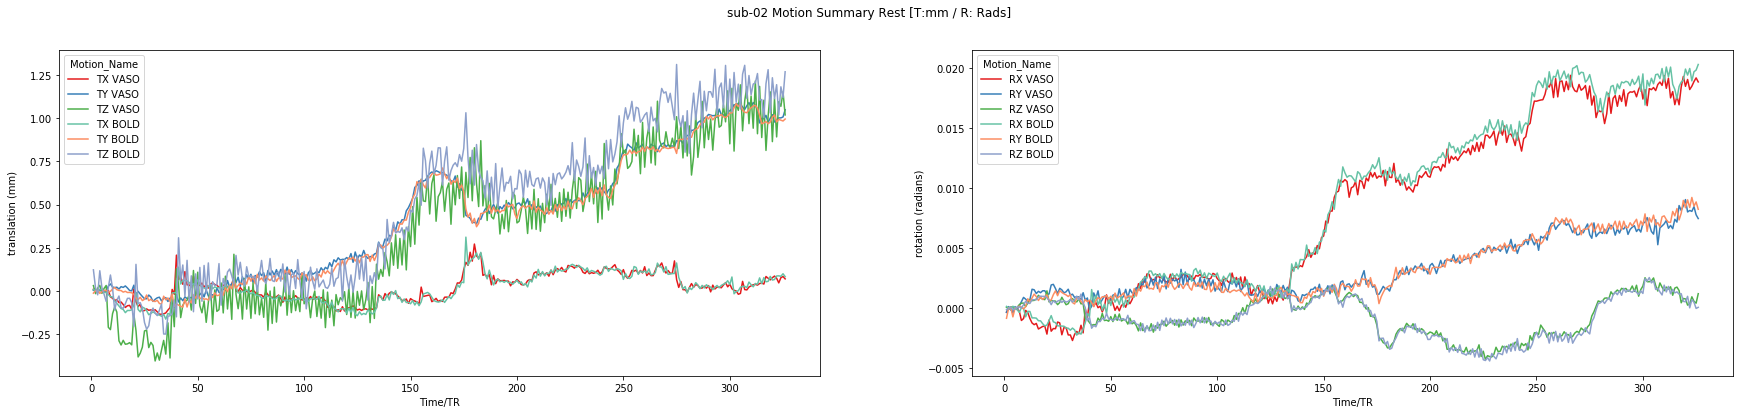

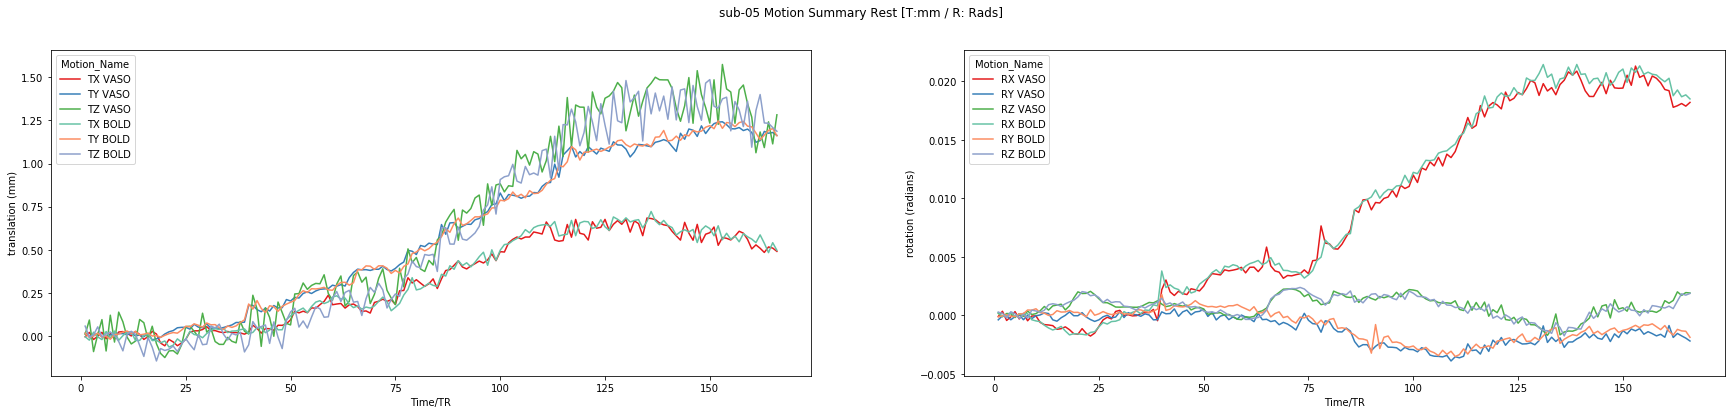

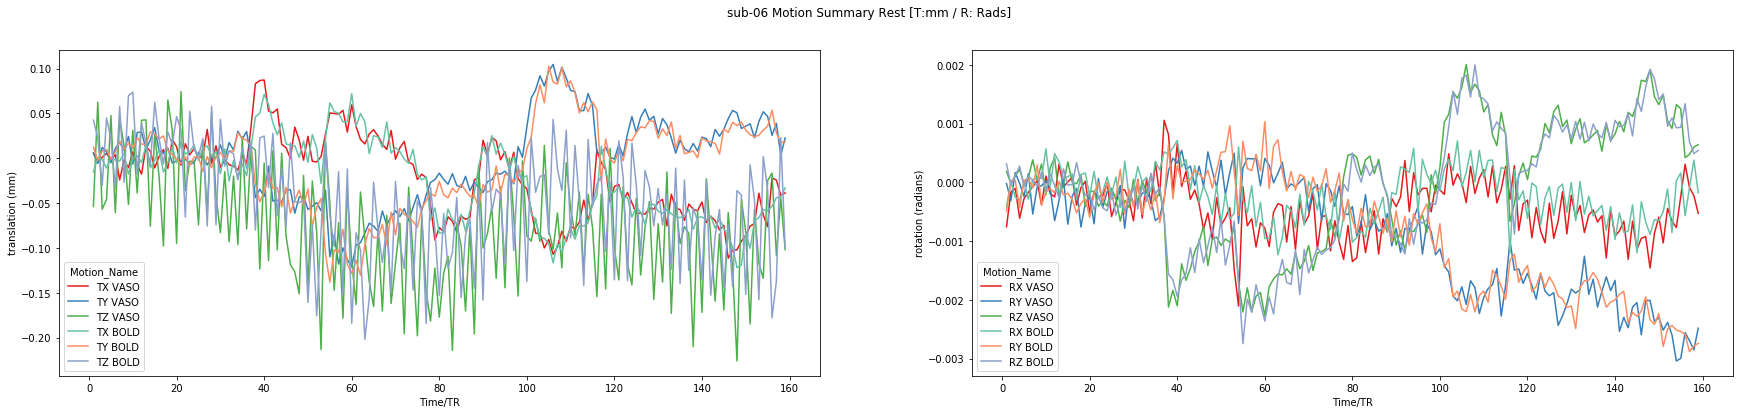

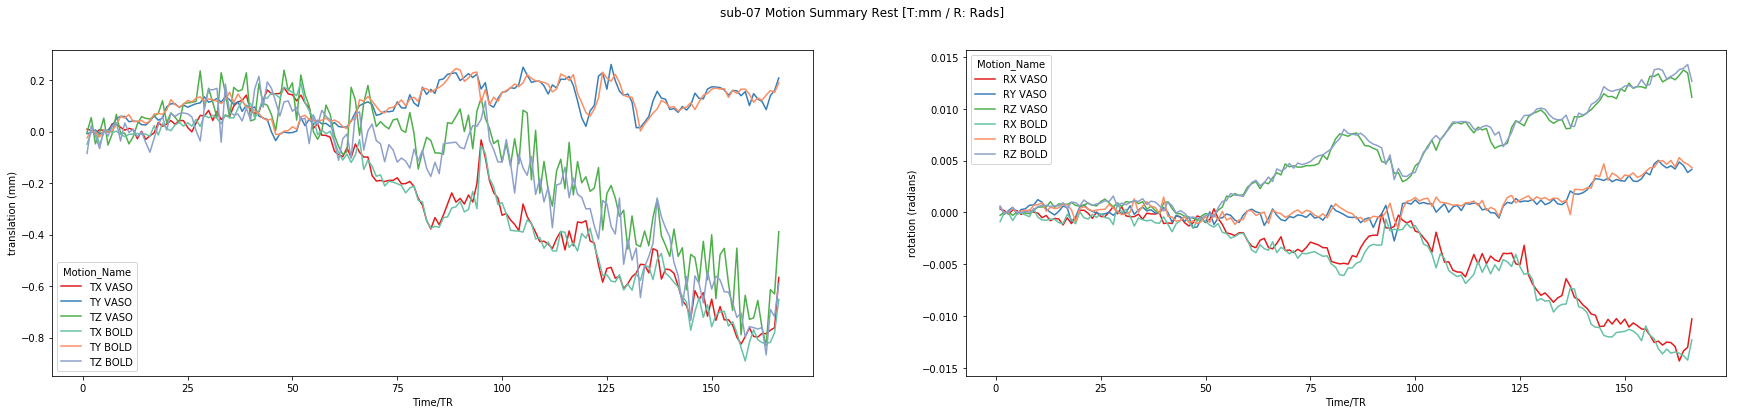

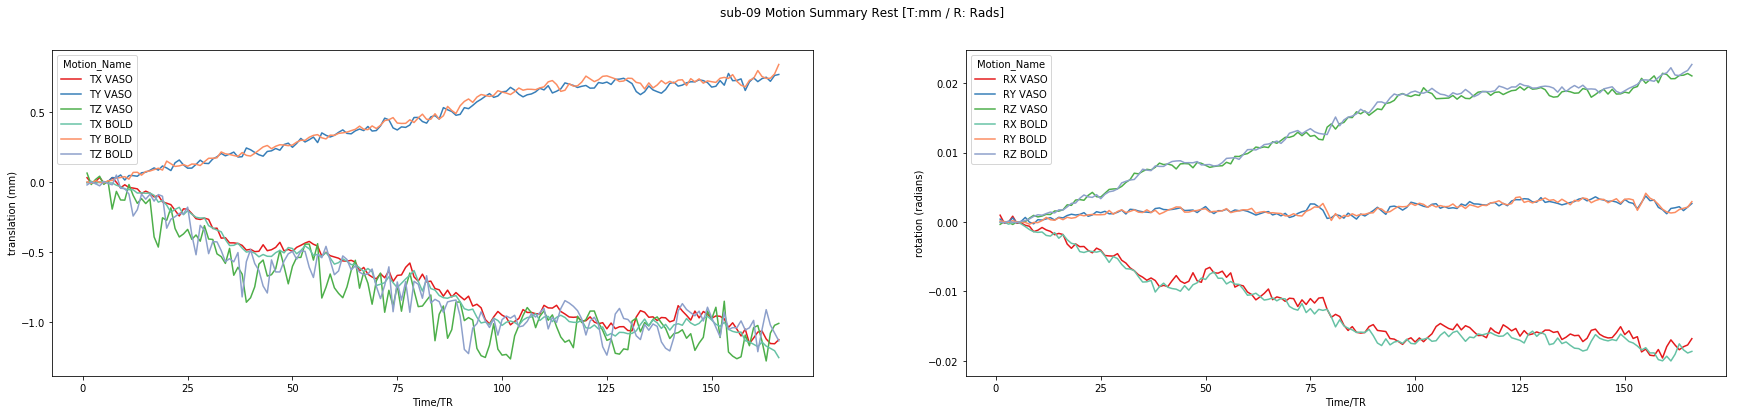

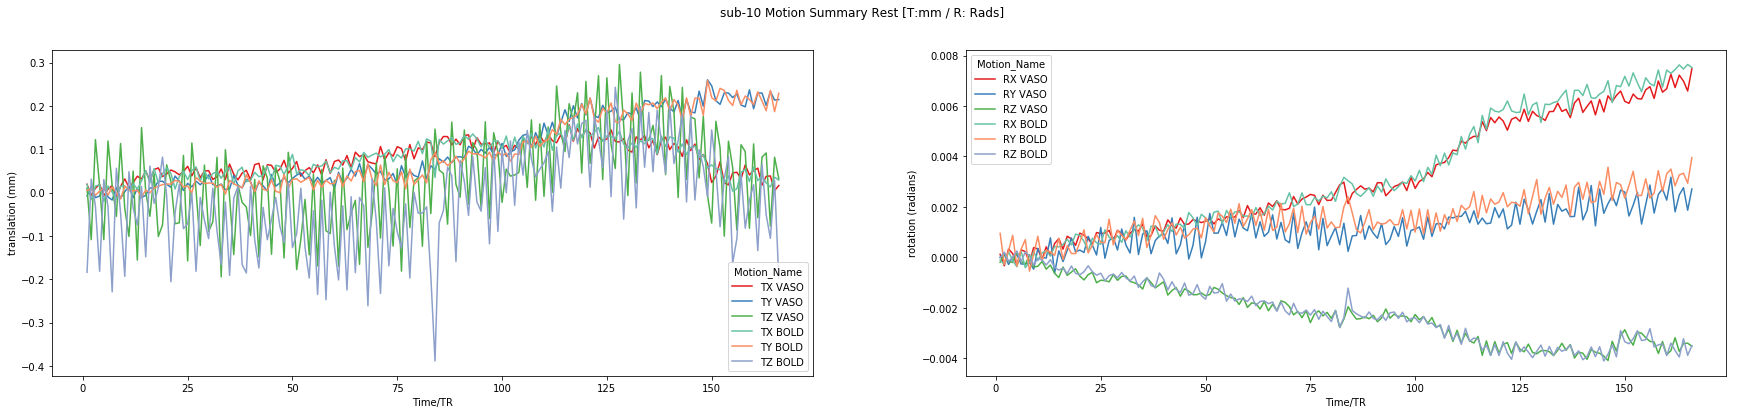

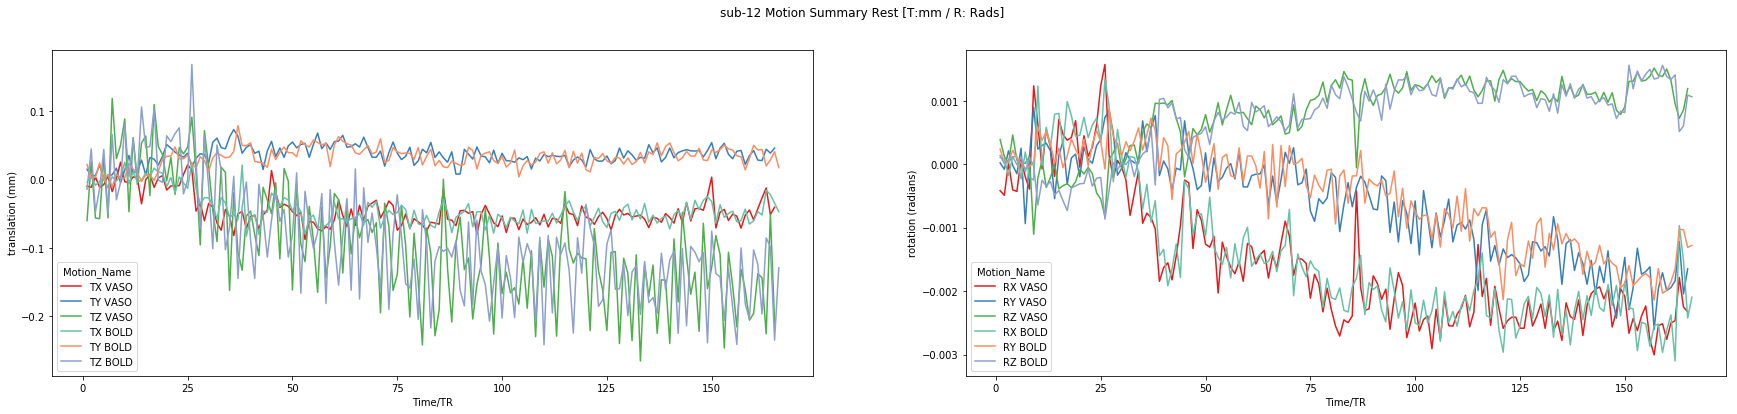

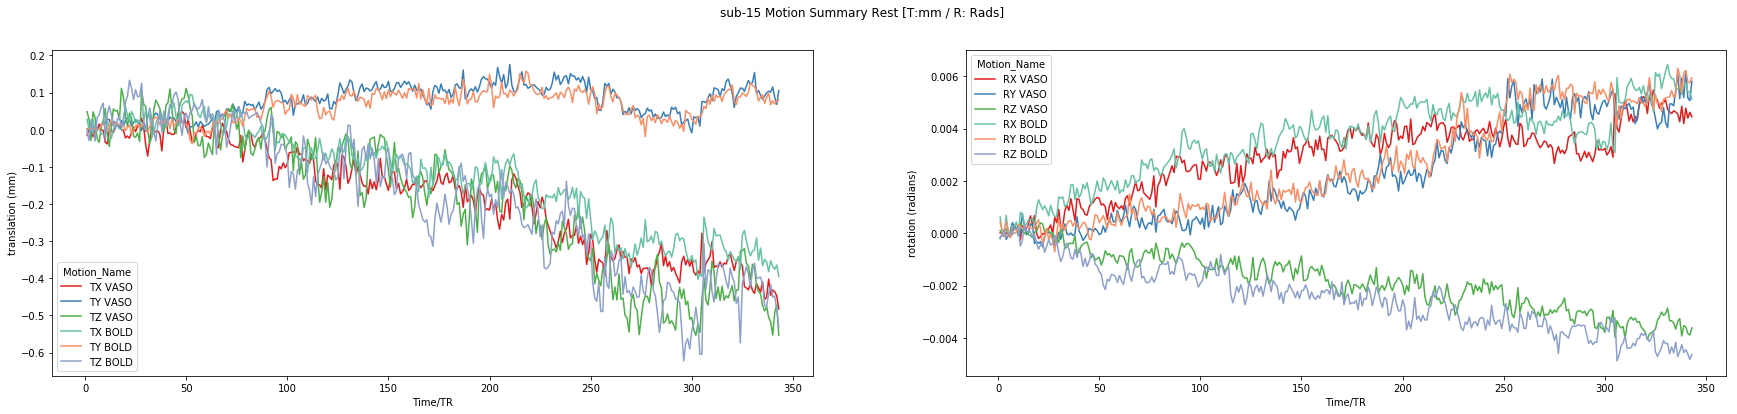

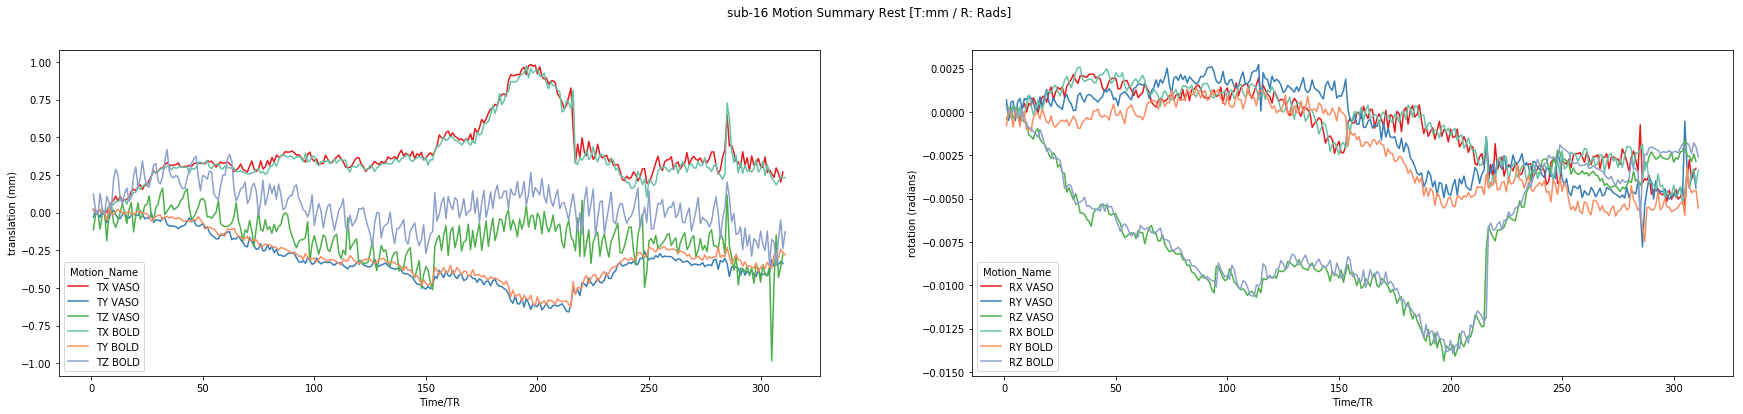

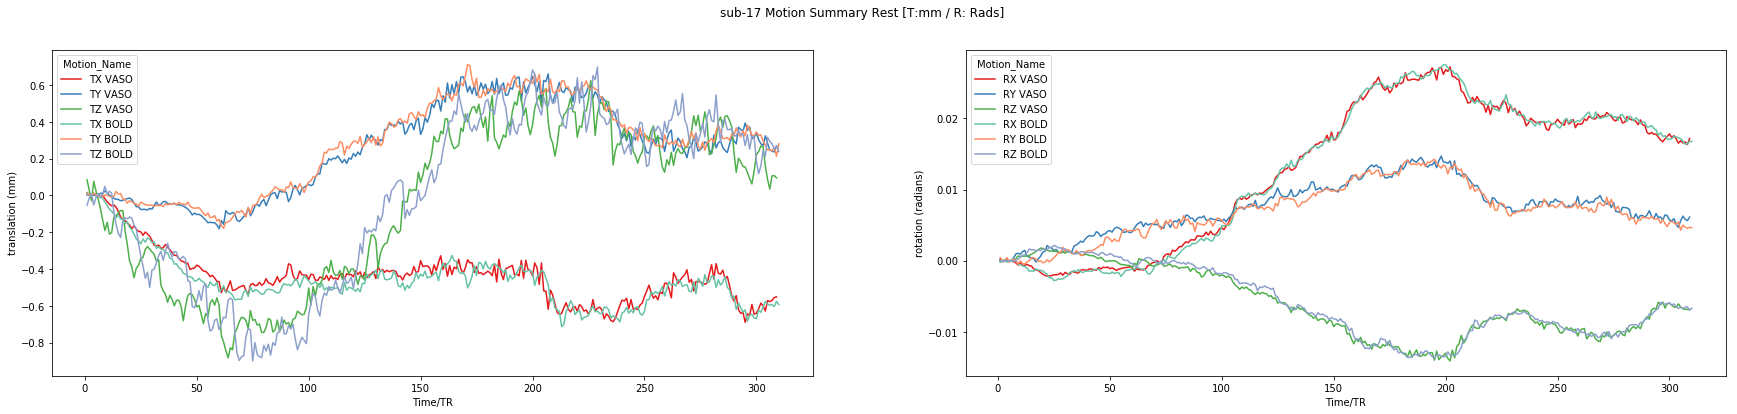

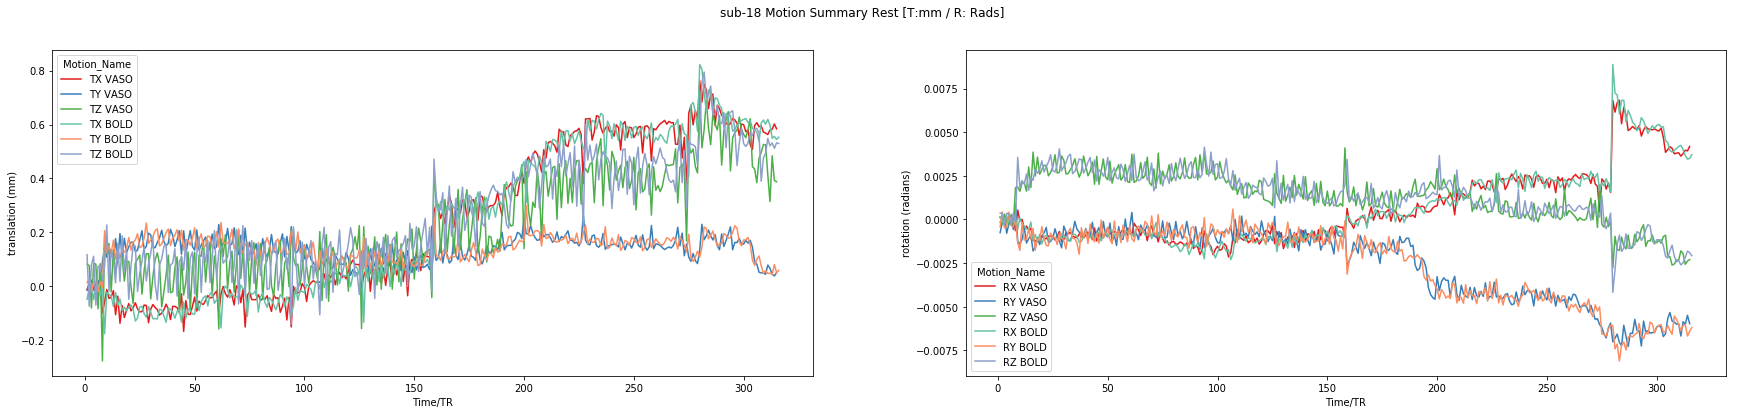

In [60]:
# Load dataFrames
restMotion = pd.read_csv(root + f'/derivatives/quality_assessmen/motionParametersRest.csv')

for sub in subs:
    restMotion_rot_VASO = restMotion.loc[(restMotion['Motion_Name'].str.contains("R") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='VASO')].dropna()
    restMotion_trans_VASO = restMotion.loc[(restMotion['Motion_Name'].str.contains("T") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='VASO')].dropna()
    
    restMotion_rot_BOLD = restMotion.loc[(restMotion['Motion_Name'].str.contains("R") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='BOLD')].dropna()
    restMotion_trans_BOLD = restMotion.loc[(restMotion['Motion_Name'].str.contains("T") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='BOLD')].dropna()
    
    
    fig, axes = plt.subplots(1, 2,sharex=True,figsize=(30,6))
    plt.suptitle('%s Motion Summary Rest [T:mm / R: Rads]'%(sub))


    sns.lineplot(ax=axes[0], x='Time/TR',y='Motion',data=restMotion_trans_VASO,hue='Motion_Name', palette = 'Set1')
    sns.lineplot(ax=axes[0], x='Time/TR',y='Motion',data=restMotion_trans_BOLD,hue='Motion_Name', palette = 'Set2')


    axes[0].set_ylabel("translation (mm)")


    sns.lineplot(ax=axes[1], x='Time/TR',y='Motion',data=restMotion_rot_VASO,hue='Motion_Name', palette = 'Set1')
    sns.lineplot(ax=axes[1], x='Time/TR',y='Motion',data=restMotion_rot_BOLD,hue='Motion_Name', palette = 'Set2')



    axes[1].set_ylabel("rotation (radians)")
    plt.savefig('/home/sebastian/Desktop/%s_motionRest.jpg'%(sub), bbox_inches = 'tight', pad_inches = 0)

### Voxel reduction of functional data

To further reduce our voxels, we copped the data to our area of interest. This involved some visual inspection. The coordinates.

In [11]:
boundariesDict = {'sub-02': [30, 110, 50, 70, 0, 21],
                  'sub-05': [10, 95, 40, 85, 0, 21],
                  'sub-06': [10, 110, 50, 70, 0, 21],
                  'sub-07': [5, 120, 30, 95, 0, 21],
                  'sub-09': [25, 105, 80, 60, 0, 21],
                  'sub-10': [10, 110, 40, 90, 0, 21],
                  'sub-12': [20, 110, 40, 90, 0, 21],
                  'sub-15': [20, 115, 40, 90, 0, 21],
                  'sub-16': [20, 110, 35, 95, 0, 21],
                  'sub-17': [30, 105, 70, 70, 0, 21],
                  'sub-18': [30, 115, 40, 90, 0, 21]
                 }


In [13]:
from nipype.interfaces.fsl import ExtractROI

for sub in subs:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-*run-00*_cbv.nii.gz'))
    
    for run in runs:
        
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(f'Processing run {base}')
    
        for dataType in ['moco_nulled', "moco_notnulled"]:
            print(dataType)

            file = f'{root}/derivatives/{sub}/func/{base}_{dataType}.nii'
            
#             # Apparently, the fslroi wrapper in nipype wants an existing file as output filename (?). Therefore, I will create one with the same dimensions.
#             tmpFile = nb.load(file)
            
#             tmp = Nifti1Image(tmpFile.get_fdata(), header=tmpFile.header, affine=tmpFile.affine)
#             save(tmp, f'{root}/derivatives/{sub}/func/{base}_{dataType}_trunc.nii.gz')


            fslroi = ExtractROI(in_file=file, roi_file= f'{root}/derivatives/{sub}/func/{base}_{dataType}_trunc.nii.gz', 
                                x_min = boundariesDict[sub][0], x_size = boundariesDict[sub][1], 
                                y_min = boundariesDict[sub][2], y_size = boundariesDict[sub][3],
                                z_min = boundariesDict[sub][4], z_size = boundariesDict[sub][5]
                               )

            out = fslroi.run()

Processing run sub-07_ses-001_task-restBA3b_run-001
moco_nulled
moco_notnulled
Processing run sub-07_ses-001_task-stim_run-001
moco_nulled
moco_notnulled
Processing run sub-07_ses-001_task-stim_run-002
moco_nulled
moco_notnulled


## BOCO and stuff

In [109]:
%%bash

for sub in 02 05 06 07 09 10 12 15 16 17 18
do

declare -a runs=('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*run-*_cbv.nii.gz')

cd '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-'$sub'/func'


for run in $runs
do

# define basename for output files
base=`basename $run _cbv.nii.gz`
echo 'processing run '$base''


##################################################
#### Temporal upsampling so VASO matches BOLD ####
##################################################

echo "temporal upsampling and shifting happens now"
3dUpsample -overwrite  -datum short -prefix ${base}_Nulled_intemp.nii -n 2 -input ${base}_moco_nulled_trunc.nii.gz
3dUpsample -overwrite  -datum short -prefix ${base}_BOLD_intemp.nii   -n 2 -input ${base}_moco_notnulled_trunc.nii.gz

##for Magentom clasical VASO sequence
NumVol=`3dinfo -nv ${base}_Nulled_intemp.nii`
3dTcat -overwrite -prefix ${base}_Nulled_intemp.nii ${base}_Nulled_intemp.nii'[0]' ${base}_Nulled_intemp.nii'[0..'`expr $NumVol - 2`']'

echo "I am correcting for the proper TR in the header"
3drefit -TR 1.9295 ${base}_BOLD_intemp.nii
3drefit -TR 1.9295 ${base}_Nulled_intemp.nii

echo "BOLD correction happens now"
LN_BOCO -Nulled ${base}_Nulled_intemp.nii -BOLD ${base}_BOLD_intemp.nii -output ${base}

echo "calculating T1 in EPI space"
3dTcat -prefix combined.nii  ${base}_moco_nulled_trunc.nii.gz ${base}_moco_notnulled_trunc.nii.gz -overwrite
3dTstat -cvarinv -overwrite  -prefix ${base}_T1w.nii combined.nii
rm combined.nii

echo "curtosis and skew"
LN_SKEW -input ${base}_BOLD_intemp.nii
LN_SKEW -input ${base}_VASO_LN.nii

The FSL GLM does not seem to like images where values are between 0 and 1. There fore, we are multipolying everything by 100.
fslmaths ${base}_VASO_LN.nii -mul 100 ${base}_VASO.nii -odt short
fslmaths ${base}_BOLD_intemp.nii -mul 1 ${base}_BOLD.nii -odt short


done
done

processing run sub-02_ses-003_task-restBA3b_run-001
temporal upsampling and shifting happens now
I am correcting for the proper TR in the header
BOLD correction happens now
LAYNII v2.0.0          
Compiled for Linux 64  
LN_BOCO

    File name: sub-02_ses-003_task-restBA3b_run-001_Nulled_intemp.nii
    Image details: 110 X | 70 Y | 21 Z | 652 T 
    Voxel size = 0.753086 x 0.753086 x 1.29
    Datatype = 4

    File name: sub-02_ses-003_task-restBA3b_run-001_BOLD_intemp.nii
    Image details: 110 X | 70 Y | 21 Z | 652 T 
    Voxel size = 0.753086 x 0.753086 x 1.29
    Datatype = 4

    !!!Warning!!! Input nifti header contains scl_scale=0.
    Make sure to check the resulting output image.

    Writing output as:
      sub-02_ses-003_task-restBA3b_run-001_VASO_LN.nii
  Finished.
calculating T1 in EPI space
curtosis and skew
LAYNII v2.0.0          
Compiled for Linux 64  
LN_SKEW

    File name: sub-02_ses-003_task-restBA3b_run-001_BOLD_intemp.nii
    Image details: 110 X | 70 Y | 21 Z |

++ 3dUpsample: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
++ Authored by: RWCox
*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_ses-003_task-restBA3b_run-001_moco_nulled_trunc.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_ses-003_task-restBA3b_run-001_moco_nulled_trunc.nii.gz is 38.554882 degrees from plumb.
++ 3dUpsample: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
++ Authored by: RWCox
*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_ses-003_task-re

## Anatomical processing


### Averaging of the 3 high resolution slabs using ITK-SNAP

To increase the SNR, I first averaged the 3 high resolution slabs we acquired.

In [3]:
# root = '/media/sebastian/Data/S1ANFUNCO/raw_data'

In [338]:
restRuns = sorted(glob.glob(root + '/sub-*/ses-00*/func/sub-*_ses-00*_task-rest*_cbv.nii.gz'))
subList = [i[-47:-41] for i in restRuns]

In [347]:
imgs

['/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-02/ses-002/anat/sub-02_ses-002_highres-mp2rage_run-001_uni.nii.gz',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-02/ses-003/anat/sub-02_ses-003_highres-mp2rage_run-001_uni.nii.gz']

In [12]:
for sub in subs[1:]:
    print(sub)
    # Define output folder
    outFolder = f'{root}/derivatives/{sub}/anat'
    
    # look for 3 anatomical images.
    imgs = sorted(glob.glob(root + f'/{sub}/ses-00*/anat/*_ses-00*_highres-mp2rage_run-00*_uni.nii.gz'))
    
    
    
    # Read reference image.
    fixed = ants.image_read(imgs[0])
    
    # Save it for easy processing in a step below
    ants.image_write(fixed, outFolder + f'/1.nii', ri=False)
    
    # Register images 2 and 3
    print('Registering')
    for img,n in zip(imgs[1:],range(2,len(imgs)+1)):
        
        moving = ants.image_read(img)
        mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Rigid')
        warped_moving = mytx['warpedmovout']
        
        # Save it for easy processing in a step below
        ants.image_write(warped_moving, outFolder + f'/{n}.nii', ri=False)
    
    # Load 3 anatomical images for averaging
    print('Averaging')
    img1 = nb.load(outFolder + f'/1.nii').get_fdata()
    img2 = nb.load(outFolder + f'/2.nii').get_fdata()
    img3 = nb.load(outFolder + f'/3.nii').get_fdata()

    # Average 3 anatomical images to increase SNR
    avg = np.add(img1, img2)
    avg = np.add(avg, img3)
    avg = np.divide(avg, 3)
    ni_img = nb.Nifti1Image(avg, nb.load(outFolder + f'/1.nii').affine)
    nb.save(ni_img, outFolder+ f'/{sub}_highres-mp2rage_uni_average.nii')
    
    # Bias field correction
    print('Bias field correction')
    image = ants.image_read(outFolder+ f'/{sub}_highres-mp2rage_uni_average.nii')
    image_n4 = ants.n4_bias_field_correction(image)
    
    # Save corrected image
    ants.image_write(image_n4, outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected.nii', ri=False)
    
    # Delete intermediate steps.
    for n in range(1,len(imgs)+1):
        os.remove(outFolder + f"/{n}.nii")

sub-05
Bias field correction
sub-06
Bias field correction
sub-07
Bias field correction
sub-09
Bias field correction
sub-10
Bias field correction
sub-12
Bias field correction
sub-15
Bias field correction
sub-16
Bias field correction
sub-17
Bias field correction
sub-18
Bias field correction


In [ ]:
# For sub-02 the acquisition of anatomical data was a bit messy due to the various sessions, 
# therefore I will do it manually here.

outFolder = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-02/anat'

# Bias field correction
image = ants.image_read(outFolder+ f'/sub-02_highres-mp2rage_uni_average.nii.gz')
image_n4 = ants.n4_bias_field_correction(image)
    
# Save corrected image
ants.image_write(image_n4, outFolder+ f'/sub-02_highres-mp2rage_uni_average_N4corrected.nii', ri=False)

### Voxel reduction

Because we are only interested in the postcentral gyrus, we will reduce our voxels with several measures.
First, we will use brain masks and then crop our data.

#### Brain mask

Automatic brain extraction is often problematic. Therefore, I manually drew outlines of the brain in every 3rd slice and dilated them with the following code:

In [17]:
for sub in subs:
    print(sub)
    
    
    outFolder = f'{root}/derivatives/manualSteps/{sub}'
    # load data
    nii = load(f'{outFolder}/{sub}_highres-mp2rage_uni_average_N4corrected_brainMask.nii.gz')

    basename = nii.get_filename().split(os.extsep, 1)[0]
    dirname = os.path.dirname(nii.get_filename())
    data = nii.get_fdata()

    # perform closing
    data = morphology.binary_dilation(data, iterations=3)
    data = morphology.binary_erosion(data, iterations=3)

    # perform opening
    #data = morphology.binary_erosion(data, iterations=1)
    #data = morphology.binary_dilation(data, iterations=1)

    # save as nifti
    out = Nifti1Image(data, header=nii.header, affine=nii.affine)
    save(out, basename + "_opening_closing.nii.gz")


    print('Morphology operations are done.')


sub-02
Morphology operations are done.
sub-05
Morphology operations are done.
sub-06
Morphology operations are done.
sub-07
Morphology operations are done.
sub-09
Morphology operations are done.
sub-10
Morphology operations are done.
sub-12
Morphology operations are done.
sub-15
Morphology operations are done.
sub-16
Morphology operations are done.
sub-17
Morphology operations are done.
sub-18
Morphology operations are done.


Then we can multiply the anatomical image with the mask.

In [49]:
for sub in subs[:1]:
    
    anatFile = f'{root}/derivatives/{sub}/anat/{sub}_highres-mp2rage_uni_average_N4corrected.nii'
    anatData = nb.load(anatFile).get_fdata()
    
    maskData = nb.load(f'{root}/derivatives/manualSteps/{sub}/{sub}_highres-mp2rage_uni_average_N4corrected_brainMask_opening_closing.nii.gz').get_fdata()
    
    # Multiply with binary brain mask to get rid of non-brain voxels.
    masekdData = np.multiply(anatData, maskData)
    
    # save as nifti
    
    affinetmp = nb.load(anatFile).affine
    ni_img = nb.Nifti1Image(masekdData, affinetmp)
    nb.save(ni_img, f'{root}/derivatives/{sub}/anat/{sub}_highres-mp2rage_uni_average_N4corrected_brain.nii')


#### Cropping

To further reduce our voxels, we copped the data to our area of interest. This involved some visual inspection. The coordinates.

In [50]:
boundariesDict = {'sub-02': [80, 170, 75, 115, 5, 51],
                  'sub-05': [110, 160, 60, 125, 7, 47],
                  'sub-06': [100, 160, 70, 90, 9, 46],
                  'sub-07': [100, 180, 70, 120, 10, 45],
                  'sub-09': [75, 175, 110, 90, 7, 47],
                  'sub-10': [90, 175, 80, 100, 9, 45],
                  'sub-12': [90, 175, 60, 110, 4, 48],
                  'sub-15': [85, 165, 80, 110, 4, 49],
                  'sub-16': [90, 160, 65, 125, 4, 51],
                  'sub-17': [80, 155, 95, 115, 4, 48],
                  'sub-18': [65, 170, 90, 115, 4, 51]
                 }



In [51]:
from nipype.interfaces.fsl import ExtractROI

for sub in subs[:1]:
    outFolder = f'{root}/derivatives/{sub}/anat'

    anatFile = outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain.nii'

#     # Apparently, the fslroi wrapper in nipype wants an existing file as output filename (?). Therefore, I will create one with the same dimensions.
#     tmpFile = nb.load(anatFile)
#     tmp = Nifti1Image(tmpFile.get_fdata(), header=tmpFile.header, affine=tmpFile.affine)
#     save(tmp, outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz')


    fslroi = ExtractROI(in_file=anatFile, roi_file= outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz', 
                        x_min = boundariesDict[sub][0], x_size = boundariesDict[sub][1], 
                        y_min = boundariesDict[sub][2], y_size = boundariesDict[sub][3],
                        z_min = boundariesDict[sub][4], z_size = boundariesDict[sub][5]
                       )

    out = fslroi.run()

### Create high quality T1-weighted images in EPI space


We want to register the MP2RAGE anatomy to the T1 weighted images in EPI space. In previous steps, we already calculated them for individual runs. However, we can imporve the images by taking into account all runs we acquired of a given subject. This will make our registration work better due to higher SNR images.

First, all necessary images are concatenated

In [53]:
substmp = ['sub-02']

In [19]:
from nipype.interfaces import afni

for sub in substmp:
    inputFiles = sorted(glob.glob(f'{root}/derivatives/{sub}/func/{sub}_*_run-00*_moco_*ulled_trunc.nii.gz'))
    tcat = afni.TCat()
    tcat.inputs.in_files = inputFiles
    tcat.inputs.out_file= f'{root}/derivatives/{sub}/func/combined.nii'

    res = tcat.run()
    
    inputFiles = sorted(glob.glob(f'{root}/derivatives/{sub}/func/{sub}_*_run-00*_moco_*ulled.nii'))
    tcat = afni.TCat()
    tcat.inputs.in_files = inputFiles
    tcat.inputs.out_file= f'{root}/derivatives/{sub}/func/combined_noTrunc.nii'

    res = tcat.run()

211115-11:23:13,42 nipype.interface INFO:
	 stderr 2021-11-15T11:23:13.042250:++ 3dTcat: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
211115-11:23:19,369 nipype.interface INFO:
	 stderr 2021-11-15T11:23:19.368950:** ERROR: output dataset name 'combined.nii' conflicts with existing file
211115-11:23:19,370 nipype.interface INFO:
	 stderr 2021-11-15T11:23:19.368950:** ERROR: dataset NOT written to disk!
211115-11:23:19,371 nipype.interface INFO:
	 stderr 2021-11-15T11:23:19.368950:++ elapsed time = 6.3 s
211115-11:23:20,41 nipype.interface INFO:
	 stderr 2021-11-15T11:23:20.041708:++ 3dTcat: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
211115-11:23:23,646 nipype.interface INFO:
	 stderr 2021-11-15T11:23:23.646795:** ERROR: output dataset name 'combined_noTrunc.nii' conflicts with existing file
211115-11:23:23,648 nipype.interface INFO:
	 stderr 2021-11-15T11:23:23.646795:** ERROR: dataset NOT written to disk!
211115-11:23:23,648 nipype.interface INFO:
	 stderr 2021-11-15T11:23:23

...and then transformed into a T1w image. Finally, we performed a bias-field correction.

In [20]:
%%bash

# for sub in 02 05 06 07 09 10 12 15 16 17 18
for sub in 07 12
do


echo Current subject: sub-$sub

cd /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-$sub/func

3dTstat -cvarinv -overwrite -prefix 'sub-'$sub'_EPI_T1w.nii' combined.nii

N4BiasFieldCorrection -d 3 -i 'sub-'$sub'_EPI_T1w.nii' -o 'sub-'$sub'_EPI_T1w_N4Corrected.nii'

3dTstat -cvarinv -overwrite -prefix 'sub-'$sub'_EPI_T1w_noTrunc.nii' combined_noTrunc.nii

N4BiasFieldCorrection -d 3 -i 'sub-'$sub'_EPI_T1w_noTrunc.nii' -o 'sub-'$sub'_EPI_T1w_noTrunc_N4Corrected.nii'

rm combined*.nii



done

Current subject: sub-07
Current subject: sub-12


++ 3dTstat: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
++ Authored by: KR Hammett & RW Cox
*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-07/func/combined.nii,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-07/func/combined.nii is 38.929794 degrees from plumb.
++ Output dataset ./sub-07_EPI_T1w.nii
++ 3dTstat: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
++ Authored by: KR Hammett & RW Cox
*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-07/func/combined_noTrunc.nii,
  or viewing/combining it with volume

### Registration

For the registration, we manually matched the average UNI images with the anatomy in EPI space in ITK-SNAP. Note, that we are registering it to the EPI-data in NATIVE resolution! In previous versions, we registered it to the upsampled data but found the results to be more satisfying in native resolution.

Then, we used the automatic registration in ITK-SNAP with the following parameters:

Transformation model: rigid
metric : mutual information
multi-resolution schedule: coarsest 2x, finest 1x

The resulting matrix was saved as "objective_matrix" and can be found in the manualSteps folder

To further improve our registration, we used the followeing code in ANTS:

In [54]:
%%bash -s "{" ".join(subs)}" "$root"


# for sub in 02 05 06 07 09 10 12 15 16 17 18
for sub in 02
do



cd $2/derivatives/sub-$sub/anat

echo Current participant: sub-$sub
echo Fixed: ''$2'/derivatives/sub-'$sub'/func/sub-'$sub'_EPI_T1w_N4Corrected.nii'
echo Moving: '/sub-'$sub'_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz'
echo ###

antsRegistration \
--verbose 1 \
--dimensionality 3  \
--float 0  \
--collapse-output-transforms 1  \
--interpolation BSpline[5] \
--output [registered1_,registered1_Warped.nii,1]  \
--use-histogram-matching 0  \
--winsorize-image-intensities [0.005,0.995]  \
--initial-moving-transform $2/derivatives/manualSteps/sub-$sub/objective_matrix.txt \
--transform SyN[0.1,3,0]  \
--metric CC[''$2'/derivatives/sub-'$sub'/func/sub-'$sub'_EPI_T1w_noTrunc_N4Corrected.nii', 'sub-'$sub'_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz',1,2]  \
--convergence [60x10,1e-6,10]  \
--shrink-factors 2x1  \
--smoothing-sigmas 1x0vox  \
# -x ''$2'/derivatives/manualSteps/sub-'$sub'/sub-'$sub'_registrationMask.nii.gz'

antsApplyTransforms \
--interpolation BSpline[5] \
-d 3 -i 'sub-'$sub'_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz' \
-r ''$2'/derivatives/sub-'$sub'/func/sub-'$sub'_EPI_T1w_noTrunc_N4Corrected.nii' \
-t registered1_1Warp.nii.gz \
-t registered1_0GenericAffine.mat \
-o 'sub-'$sub'_highres-mp2rage_uni_average_N4corrected_brain_trunc_registered.nii'

done

Current participant: sub-02
Fixed: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_EPI_T1w_N4Corrected.nii
Moving: /sub-02_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz

All_Command_lines_OK
Using double precision for computations.
The composite transform comprises the following transforms (in order): 
  1. /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/manualSteps/sub-02/objective_matrix.txt (type = MatrixOffsetTransformBase)
  number of levels = 2
  fixed image: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_EPI_T1w_noTrunc_N4Corrected.nii
  moving image: sub-02_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz
Dimension = 3
Number of stages = 1
Use Histogram Matching false
Winsorize image intensities true
Lower quantile = 0.005
Upper quantile = 0.995
Stage 1 State
   Image metric = CC
     Fixed image = Image (0x55c847196de0)
  RTTI typeinfo:   itk::Image<double,

crop registered anat

In [55]:
boundariesDict = {'sub-02': [30, 110, 50, 70, 0, 21],
                  'sub-05': [10, 95, 40, 85, 0, 21],
                  'sub-06': [10, 110, 50, 70, 0, 21],
                  'sub-07': [5, 120, 30, 95, 0, 21],
                  'sub-09': [25, 105, 80, 60, 0, 21],
                  'sub-10': [10, 110, 40, 90, 0, 21],
                  'sub-12': [20, 110, 40, 90, 0, 21],
                  'sub-15': [20, 115, 40, 90, 0, 21],
                  'sub-16': [20, 110, 35, 95, 0, 21],
                  'sub-17': [30, 105, 70, 70, 0, 21],
                  'sub-18': [30, 115, 40, 90, 0, 21]
                 }

In [56]:
from nipype.interfaces.fsl import ExtractROI

for sub in substmp:
    outFolder = f'{root}/derivatives/{sub}/anat'

    anatFile = outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc_registered.nii'

    fslroi = ExtractROI(in_file=anatFile, roi_file= outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain_registered_trunc.nii.gz', 
                        x_min = boundariesDict[sub][0], x_size = boundariesDict[sub][1], 
                        y_min = boundariesDict[sub][2], y_size = boundariesDict[sub][3],
                        z_min = boundariesDict[sub][4], z_size = boundariesDict[sub][5]
                       )

    out = fslroi.run()

#### Visual inspection of registration.

- sub-02 - 
- sub-05 - 
- sub-06
- sub-07
- sub-09
- sub-10
- sub-12
- sub-15
sub-16
sub-17
sub-18



In [71]:
path = os.getcwd()
dumpFolder = path + "/tmpGifImages"

try:
    os.mkdir(dumpFolder)

except OSError:
    print ("Creation of the dump directory %s failed" % path)
else:
    print ("Successfully created the dump directory in: %s " % path)


for sub in substmp:    
    
    
    anatEPI = f'{root}/derivatives/{sub}/func/{sub}_EPI_T1w_N4Corrected.nii'
    anatMP2RAGE = f'{root}/derivatives/{sub}/anat/registration/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc_registered.nii'



    for ind, image in enumerate([anatEPI, anatMP2RAGE]):


        anatEPIArr = nb.load(image).get_fdata()


        imgData = anatEPIArr[:,:,int(5)]
        rotated_img = ndimage.rotate(imgData, 90)

    #     rotated_img = rotated_img.astype(np.float64)  # normalize the data to 0 - 1
    #     rotated_img = 255 * rotated_img # Now scale by 255
    #     img = rotated_img.astype(np.uint8)
        imageio.imwrite(f'{dumpFolder}/{sub}_{ind}.png', rotated_img)


    files = sorted(glob.glob(dumpFolder + f'/{sub}*.png'))
    print(f'Creating gif from {len(files)} images')
    images = []
    for file in files:
        filedata = imageio.imread(file)
        images.append(filedata)

    imageio.mimsave(f'{dumpFolder}/{sub}_registration.gif', images, duration = 1)
    # print('Deleting dump directory')
    # os.system(f'rm -r {dumpFolder}')
    print('Done.')

Lossy conversion from float64 to uint8. Range [0.255181819200516, 36.61966705322266]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-496.25321676025726, 3750.8604767009933]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.18690554797649392, 31.959794998168945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-535.9696699622853, 3544.533587527161]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.23416940867900848, 49.18855667114258]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-354.60723329493965, 3281.872199816636]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2658704221248628, 22.2673320770263

Creation of the dump directory /home/sebastian/git failed
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.


Lossy conversion from float64 to uint8. Range [-843.7058697709532, 3454.2799345455614]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.038166046142579, 36.46849822998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-328.47654108168643, 3977.065701927468]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.40872314572334323, 26.442329406738292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-540.5242472464407, 3819.656165437238]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.5134537220001223, 34.180316925048835]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-403.6066709770198, 3726.059057275908

Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.
Creating gif from 2 images
Done.


### Segmentation

We started the segmentation process with an automatic segmentation using FSL FAST:

In [57]:
from nipype.interfaces import fsl

for sub in substmp:
    fastr = fsl.FAST()
    fastr.inputs.in_files = f'{root}/derivatives/{sub}/anat/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz'
    out = fastr.run()

We do not want to use the entire segmentation. Therefore, we created a mask that contains the post-central gyrus only and saved it as "sub-XX_highres-mp2rage_uni_average_N4corrected_brain_trunc_mask-postCentral.nii.gz" in the manualSteps folder.

The segmetntation was then manually corrected and can be found in the manualSteps forlder with the name:

'{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected.nii.gz'

The segmentation was then multiplied by the post-central gyrus mask.

In [41]:
substmp = ['sub-17', 'sub-18']

In [58]:
%%bash -s "{" ".join(substmp)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}

for (( j=0; j<$len; j++ ))
do

cd $2

fslmaths derivatives/manualSteps/${subsList[$j]}/${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected.nii.gz -mul derivatives/manualSteps/${subsList[$j]}/${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_mask-postCentral.nii.gz derivatives/${subsList[$j]}/anat/${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected_postCentral.nii.gz

done

Because the post-central gyrus mask might have ended together with GM and thus leave GM bordering with voxels without a value, we change the value every voxel that is 0 to 1.

In [59]:
substmp

['sub-02']

In [60]:
%%bash -s "{" ".join(substmp)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}
# len=1
for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}/anat

3dcalc -a ${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected_postCentral.nii.gz -prefix emptyVoxels.nii.gz -overwrite -expr "equals(0,a)"

fslmaths ${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected_postCentral.nii.gz -add emptyVoxels.nii.gz ${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected_postCentral.nii.gz

rm emptyVoxels.nii.gz

done

++ 3dcalc: AFNI version=AFNI_21.1.07 (May 11 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./emptyVoxels.nii.gz


#### Register segmentation

then we can register the segmentation

In [61]:
%%bash -s "{" ".join(substmp)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}
# len=1

for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}/anat/


antsApplyTransforms \
--interpolation MultiLabel \
-d 3 -i ${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected_postCentral.nii.gz \
-r ../func/${subsList[$j]}_EPI_T1w_noTrunc_N4Corrected.nii \
-t registered1_1Warp.nii.gz \
-t registered1_0GenericAffine.mat \
-o ${subsList[$j]}_registered_Segmentation.nii

done

and truncate it to the voxels we are interested in.

In [62]:
boundariesDict = {'sub-02': [30, 110, 50, 70, 0, 21],
                  'sub-05': [10, 95, 40, 85, 0, 21],
                  'sub-06': [10, 110, 50, 70, 0, 21],
                  'sub-07': [5, 120, 30, 95, 0, 21],
                  'sub-09': [25, 105, 80, 60, 0, 21],
                  'sub-10': [10, 110, 40, 90, 0, 21],
                  'sub-12': [20, 110, 40, 90, 0, 21],
                  'sub-15': [20, 115, 40, 90, 0, 21],
                  'sub-16': [20, 110, 35, 95, 0, 21],
                  'sub-17': [30, 105, 70, 70, 0, 21],
                  'sub-18': [30, 115, 40, 90, 0, 21]
                 }

In [63]:
from nipype.interfaces.fsl import ExtractROI

for sub in substmp:
    outFolder = f'{root}/derivatives/{sub}/anat'

    segFile = outFolder+ f'/{sub}_registered_Segmentation.nii'

    fslroi = ExtractROI(in_file=segFile, roi_file= outFolder+ f'/{sub}_registered_Segmentation_trunc.nii.gz', 
                        x_min = boundariesDict[sub][0], x_size = boundariesDict[sub][1], 
                        y_min = boundariesDict[sub][2], y_size = boundariesDict[sub][3],
                        z_min = boundariesDict[sub][4], z_size = boundariesDict[sub][5]
                       )

    out = fslroi.run()

### spatial upsampling

In order to work with layers, we have to spatially upsample everything we need for that. The components are:

1. The MP2RAGE images (to guide the improvement of the segmentation)
2. The T1w images in EPI space (to guide the improvement of the segmentation)
3. The segmentation
4. The timecourses

In [64]:
%%bash -s "{" ".join(substmp)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}

for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}


# upsampling T1w in EPI
c3d func/${subsList[$j]}_EPI_T1w_N4Corrected.nii -resample 500x500x100% -interpolation Cubic -o func/${subsList[$j]}_EPI_T1w_N4Corrected_scaled.nii

# upsampling MP2RAGE
c3d anat/${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_registered_trunc.nii -resample 500x500x100% -interpolation Cubic -o anat/${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_registered_scaled.nii
# upsampling segmentation
c3d anat/${subsList[$j]}_registered_Segmentation_trunc.nii.gz -split -foreach -resample 500x500x100% -interpolation Cubic -smooth 4x4x0vox -endfor -merge -o anat/${subsList[$j]}_registered_Segmentation_scaled.nii


done

The file-size of the timecourses explodes during upsampling, which makes them very cumbersome to handle. Therefore, we split them into individual volumes and work with them like this.

In [110]:
%%bash -s "{" ".join(subs)}" "$root"


for sub in 02 05 06 07 09 10 12 15 16 17 18
do

declare -a runs=('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-'$sub'/ses-00*/func/sub-'$sub'*rest*run-*_cbv.nii.gz')

cd '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-'$sub'/func'

mkdir scaledVolumes

for run in $runs
do

# define basename for output files
base=`basename $run _cbv.nii.gz`
echo 'processing run '$base''


for modality in BOLD VASO
do

tr=1
basevol=1000 # ANTs indexing



ImageMath 4 ''${base}'_'$modality'_vol_.nii' TimeSeriesDisassemble ${base}_$modality.nii.gz # vol_1000.nii, vol_1001.nii ...



n_vols=`PrintHeader ${base}_$modality.nii.gz | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`



nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "upsampling"
for i in $(eval echo "{$basevol..$nthvol}");
do

c3d ''${base}'_'$modality'_vol_'${i}'.nii' -resample 500x500x100% -interpolation Cubic -type short -o 'scaledVolumes/'${base}'_'$modality'_vol_'${i}'_scaled.nii'


done

rm *vol_*.nii

done
done
done

processing run sub-02_ses-003_task-restBA3b_run-001
upsampling
upsampling
processing run sub-05_ses-002_task-restBA3b_run-001
upsampling
upsampling
processing run sub-06_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-07_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-09_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-10_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-12_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-15_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-16_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-17_ses-001_task-restBA3b_run-001
upsampling
upsampling
processing run sub-18_ses-001_task-restBA3b_run-001
upsampling
upsampling


mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists
mkdir: cannot create directory ‘scaledVolumes’: File exists


### improving segmentation

The registered and upsampled segmentation was then corrected manually and can be found in the manualSteps folder.

### Layerification

Then we can create a rim file that will be read by laynii and generate layers.

In [85]:
root

'/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'

In [130]:
%%bash -s "{" ".join(subs)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}
# len=1

for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}/anat/


# 3dcalc -a $2/derivatives/manualSteps/${subsList[$j]}/${subsList[$j]}_registered_Segmentation_scaled_corrected.nii.gz -prefix ${subsList[$j]}_binary_CSF.nii.gz -overwrite -expr "equals(1,a)"
# 3dcalc -a $2/derivatives/manualSteps/${subsList[$j]}/${subsList[$j]}_registered_Segmentation_scaled_corrected.nii.gz -prefix ${subsList[$j]}_binary_GM.nii.gz -overwrite -expr "equals(2,a)"
# 3dcalc -a $2/derivatives/manualSteps/${subsList[$j]}/${subsList[$j]}_registered_Segmentation_scaled_corrected.nii.gz -prefix ${subsList[$j]}_binary_WM.nii.gz -overwrite -expr "equals(3,a)"



# fslmaths ${subsList[$j]}_binary_WM.nii.gz -mul 2 ${subsList[$j]}_rim_WM.nii.gz
# fslmaths ${subsList[$j]}_binary_GM.nii.gz -mul 3 ${subsList[$j]}_rim_GM.nii.gz
# fslmaths ${subsList[$j]}_binary_CSF.nii.gz -add ${subsList[$j]}_rim_WM.nii.gz -add ${subsList[$j]}_rim_GM.nii.gz ${subsList[$j]}_rim.nii

# LN2_LAYERS -rim ${subsList[$j]}_rim.nii.gz -nr_layers 12
LN2_LAYERS -rim ''${subsList[$j]}'_rim.nii.gz' -nr_layers 3 -equivol -output ''${subsList[$j]}'_3'

done

LAYNII v2.0.0          
Compiled for Linux 64  
LN2_LAYERS

    File name: sub-02_rim.nii.gz
    Image details: 550 X | 350 Y | 21 Z | 1 T 
    Voxel size = 0.150617 x 0.150617 x 1.29
    Datatype = 16

  Nr. layers: 3

  Start growing from inner GM (WM-facing border)...

  Start growing from outer GM...

  Start layering (equi-distant)...
    Writing output as:
      sub-02_3_metric_equidist.nii
    Writing output as:
      sub-02_3_layers_equidist.nii

  Start finding middle gray matter (equi-distant)...
    Writing output as:
      sub-02_3_midGM_equidist.nii

  Start equi-volume stage...

  Start computing equi-volume factors...

  Start smoothing equi-volume transitions...
    Iteration: 100/100

  Start final layering...
    Writing output as:
      sub-02_3_layers_equivol.nii
    Writing output as:
      sub-02_3_metric_equivol.nii

  Start finding middle gray matter (equi-volume)...
    Writing output as:
      sub-02_3_midGM_equivol.nii
    Writing output as:
      sub-02_3_th

### extract confound timecourses

In [111]:
for sub in subs:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-*run-00*_cbv.nii.gz'))
    
    for run in runs:
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(f'Processing run {base}')
        
        for modality in ['VASO','BOLD']:
            print(modality)
            
            for tissueType in ['WM']:
                confoundTimecourse = []
                
                
                dataLowRes =  nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata()
                
                timetpoints = dataLowRes.shape[-1]
                

                confoundMask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_registered_Segmentation_trunc.nii.gz').get_fdata()
                confoundMask[confoundMask < 3] = 0
                
                for timepoint in range(timetpoints):
#                     tmp = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{timepoint+1000}_scaled.nii').get_fdata()
                    confoundTimecourse.append(np.mean((dataLowRes[:, :, :,timepoint][confoundMask.astype(bool)]),axis=0))
                confoundArr = np.array(confoundTimecourse)
                np.savetxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_{tissueType}_confounds.txt', confoundArr, delimiter='/n')


Processing run sub-02_ses-003_task-restBA3b_run-001
VASO
BOLD
Processing run sub-02_ses-003_task-stim_run-001
VASO
BOLD
Processing run sub-02_ses-003_task-stim_run-002
VASO
BOLD
Processing run sub-05_ses-002_task-restBA3b_run-001
VASO
BOLD
Processing run sub-05_ses-002_task-stim_run-001
VASO
BOLD
Processing run sub-06_ses-001_task-restBA3b_run-001
VASO
BOLD
Processing run sub-06_ses-001_task-stim_run-001
VASO
BOLD
Processing run sub-07_ses-001_task-restBA3b_run-001
VASO
BOLD
Processing run sub-07_ses-001_task-stim_run-001
VASO
BOLD
Processing run sub-07_ses-001_task-stim_run-002
VASO
BOLD
Processing run sub-09_ses-001_task-restBA3b_run-001
VASO
BOLD
Processing run sub-09_ses-001_task-stim_run-001
VASO
BOLD
Processing run sub-10_ses-001_task-restBA3b_run-001
VASO
BOLD
Processing run sub-10_ses-001_task-stim_run-001
VASO
BOLD
Processing run sub-12_ses-001_task-restBA3b_run-001
VASO
BOLD
Processing run sub-12_ses-001_task-stim_run-001
VASO
BOLD
Processing run sub-12_ses-001_task-stim_run-

### Merge confounds

1. motion outliers
2. WM
3. CSF
4. Motion traces

In [11]:
for sub in subs:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))
    
    for run in runs:
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(f'Processing run {base}')
               
        
                
        for modality in ['VASO', 'BOLD']:
            
            dataLowRes = f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz'
                
            timetpoints = nb.load(dataLowRes).get_fdata().shape[-1] 
            
            WM = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_WM_confounds.txt')
#             CSF = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_CSF_confounds.txt')
            motionTraces = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_motionParameters.txt')
            motionOutliers = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_motionOutliers.txt')
            
            print(f'This {modality}-run has {timetpoints} timepoint')
            print(WM.shape)
#             print(CSF.shape)
            print(motionTraces.shape)
            print(motionOutliers.shape)
            

            nrOfColumns = 7 + motionOutliers.shape[1]

            mergedConfounds = np.zeros((nrOfColumns,timetpoints))
            
            motionTraces = motionTraces.reshape(motionTraces.shape[0],motionTraces.shape[1]).copy()
            motionOutliers = motionOutliers.reshape(motionOutliers.shape[0],motionOutliers.shape[1]).copy()
            
            WM = WM.reshape(WM.shape[0],1).copy()
#             CSF = CSF.reshape(CSF.shape[0],1).copy()
            
            
            mergedConfounds = motionTraces.copy()
            mergedConfounds = np.hstack((mergedConfounds, WM))
#             mergedConfounds = np.hstack((mergedConfounds, CSF))
            mergedConfounds = np.hstack((mergedConfounds, motionOutliers))
            
            
            np.savetxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_mergedConfounds.txt', mergedConfounds, delimiter=' ')
           
            

Processing run sub-02_ses-003_task-restBA3b_run-001
This VASO-run has 652 timepoint
(652,)
(652, 6)
(652, 9)
This BOLD-run has 652 timepoint
(652,)
(652, 6)
(652, 8)
Processing run sub-05_ses-002_task-restBA3b_run-001
This VASO-run has 332 timepoint
(332,)
(332, 6)
(332, 13)
This BOLD-run has 332 timepoint
(332,)
(332, 6)
(332, 8)
Processing run sub-06_ses-001_task-restBA3b_run-001
This VASO-run has 318 timepoint
(318,)
(318, 6)
(318, 7)
This BOLD-run has 318 timepoint
(318,)
(318, 6)
(318, 6)
Processing run sub-07_ses-001_task-restBA3b_run-001
This VASO-run has 332 timepoint
(332,)
(332, 6)
(332, 4)
This BOLD-run has 332 timepoint
(332,)
(332, 6)
(332, 6)
Processing run sub-09_ses-001_task-restBA3b_run-001
This VASO-run has 332 timepoint
(332,)
(332, 6)
(332, 11)
This BOLD-run has 332 timepoint
(332,)
(332, 6)
(332, 11)
Processing run sub-10_ses-001_task-restBA3b_run-001
This VASO-run has 332 timepoint
(332,)
(332, 6)
(332, 3)
This BOLD-run has 332 timepoint
(332,)
(332, 6)
(332, 4)
P